<a href="https://colab.research.google.com/github/barbaraluizaoliveira/projeto-final-telos/blob/main/Analise_Priorizacao_Vulnerabilidades_Versao_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Análise de Dados para Priorização Inteligente de Vulnerabilidades

## 🧩 1. Contextualização

O aumento constante das vulnerabilidades reportadas (CVEs) torna desafiador para as equipes de segurança priorizar quais devem ser tratadas primeiro.  
A abordagem tradicional, baseada apenas em métricas como **CVSS**, pode levar à sobrecarga das equipes e à priorização incorreta de riscos.

Este notebook tem como objetivo **analisar dados de vulnerabilidades e propor critérios inteligentes de priorização**, levando em conta fatores complementares que refletem o risco real de exploração:

- **EPSS (Exploit Prediction Scoring System)** — estima a probabilidade de uma vulnerabilidade ser explorada no mundo real.
- **CISA KEV (Known Exploited Vulnerabilities)** — lista mantida pela CISA contendo CVEs com evidência confirmada de exploração ativa (“in the wild”), essenciais para identificar riscos imediatos.
- **NVD (National Vulnerability Database)** — banco de dados oficial mantido pelo NIST que reúne informações detalhadas sobre CVEs, incluindo o **CVSS score**, e serve como principal fonte de dados para esta análise.


---


## 📦 2. Importação das Bibliotecas

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##📥 3. Importação dos Datasets

In [166]:
df = pd.read_csv('/content/epss_scores_limpos.csv')
df.head()

,cve_id,risco_epss,epss_score_pct,epss_percentile_pct,epss_score,epss_percentile
0,CVE-2024-27198,CRÍTICO,95.0,100.0,0.95,1.0
1,CVE-2017-1000353,CRÍTICO,95.0,100.0,0.95,1.0
2,CVE-2023-23752,CRÍTICO,95.0,100.0,0.95,1.0
3,CVE-2017-8917,CRÍTICO,95.0,100.0,0.95,1.0
4,CVE-2024-56145,CRÍTICO,94.0,100.0,0.94,1.0


In [167]:
df_nvd = pd.read_csv('/content/nvd_join_cisa_kev_20251025_001019.csv')
df_nvd.head()

/tmp/ipython-input-442073100.py:1: DtypeWarning: Columns (5,6,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nvd = pd.read_csv('/content/nvd_join_cisa_kev_20251025_001019.csv')


,id_cve,explorada_ativamente,pontuacao_cvss_v3,gravidade_do_cvss_v3,data_publicacao,kev_data_inclusao,kev_prazo_limite,kev_prazo_dias,kev_ransomware,kev_fabricante,...,status_vulnerabilidade,vetor_de_ataque,complexidade_de_ataque,privileges_required,interção_do_usuario,impacto_da_confidencialidade,impacto_na_integridade,impacto_da_disponibilidade,pontuacao_de_explorabilidade_v3,pontuacao_de_impacto_v3
0,CVE-2020-14871,SIM - Explorada (KEV),10.0,CRITICAL,21/10/2020,11/3/2021,5/3/2022,181.0,Unknown,Oracle,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,3.9,6.0
1,CVE-2021-22893,SIM - Explorada (KEV),10.0,CRITICAL,23/04/2021,11/3/2021,23/04/2021,-194.0,Known,Ivanti,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,3.9,6.0
2,CVE-2021-22205,SIM - Explorada (KEV),10.0,CRITICAL,23/04/2021,11/3/2021,17/11/2021,14.0,Known,GitLab,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,3.9,6.0
3,CVE-2021-28799,SIM - Explorada (KEV),10.0,CRITICAL,13/05/2021,31/03/2022,21/04/2022,21.0,Known,QNAP,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,3.9,6.0
4,CVE-2021-30116,SIM - Explorada (KEV),10.0,CRITICAL,9/7/2021,11/3/2021,17/11/2021,14.0,Known,Kaseya,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,3.9,6.0


##📈 6. Análise Exploratória

## 🚀 Etapa 1: Definição do Problema (“A Dor” Atual)

O objetivo desta etapa é demonstrar, com dados, que o método atual de priorização baseado **somente no CVSS** é insustentável.

### Perguntas a responder:
- Qual é o tamanho total do universo de ameaças?
- Quantas novas CVEs foram publicadas nos últimos 12 meses?
- Qual a distribuição por severidade (Crítica, Alta, Média, Baixa)?
- Quantas vulnerabilidades “Críticas” surgiram no último ano?


In [168]:
df_nvd['data_publicacao'] = pd.to_datetime(df_nvd['data_publicacao'], errors='coerce')
df_nvd['ano_publicacao'] = df_nvd['data_publicacao'].dt.year
cves_por_ano = df_nvd.groupby('ano_publicacao')['id_cve'].count().reset_index()
cves_por_ano.rename(columns={'id_cve': 'quantidade_cves'}, inplace=True)
cves_por_ano

/tmp/ipython-input-375675909.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nvd['data_publicacao'] = pd.to_datetime(df_nvd['data_publicacao'], errors='coerce')


,ano_publicacao,quantidade_cves
0,2020,3560
1,2021,20149
2,2022,25062
3,2023,28817
4,2024,39510
5,2025,32830


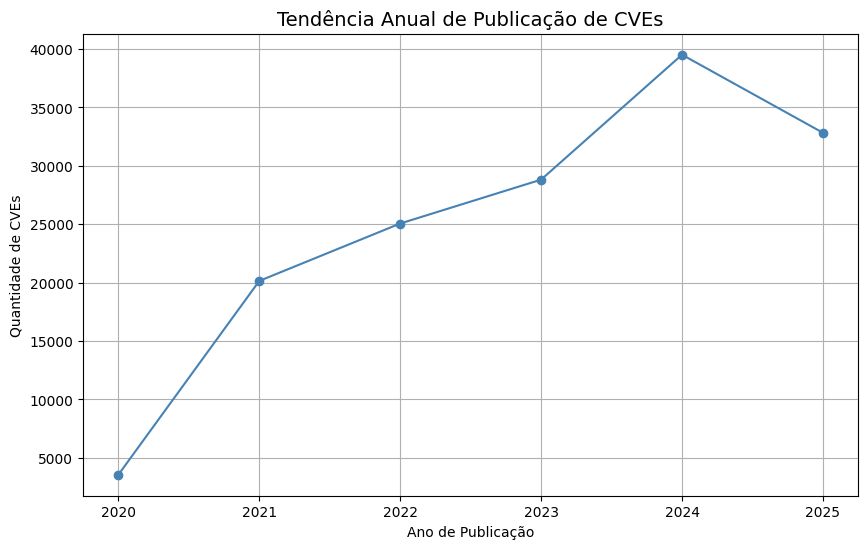

In [169]:
plt.figure(figsize=(10,6))
plt.plot(cves_por_ano['ano_publicacao'], cves_por_ano['quantidade_cves'], marker='o', color='steelblue')
plt.title('Tendência Anual de Publicação de CVEs', fontsize=14)
plt.xlabel('Ano de Publicação')
plt.ylabel('Quantidade de CVEs')
plt.grid(True)
plt.show()

In [170]:
data_max = df_nvd['data_publicacao'].max()
data_limite = data_max - pd.DateOffset(years=2)

df_nvd_recentes = df_nvd[df_nvd['data_publicacao'] >= data_limite]

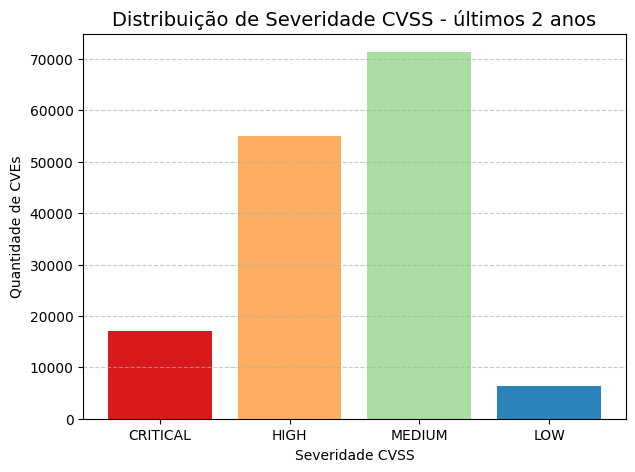

In [171]:
plt.figure(figsize=(7,5))
plt.bar(df_plot['Severidade'], df_plot['Quantidade'], color=['#d7191c','#fdae61','#abdda4','#2b83ba'])
plt.title('Distribuição de Severidade CVSS - últimos 2 anos', fontsize=14)
plt.xlabel('Severidade CVSS')
plt.ylabel('Quantidade de CVEs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##⚠️ Etapa 2: A Realidade da Exploração — Risco Real vs. Teórico
O objetivo desta etapa é demonstrar, com dados, que o método atual de priorização baseado somente no CVSS é insustentável.


### Perguntas a responder:
- Qual é a verdadeira taxa de exploração de vulnerabilidades "Críticas"?
Qual é a verdadeira taxa de exploração de vulnerabilidades "Críticas"?
- Existem vulnerabilidades na lista CISA KEV que não são "Críticas"? (Ex: Quantas são 'Médias' ou 'Altas'?)


In [172]:
df_nvd['pontuacao_cvss_v3'] = pd.to_numeric(
    df_nvd['pontuacao_cvss_v3'].astype(str).str.replace(',', '.'),
    errors='coerce'
)

df_criticas = df_nvd[df_nvd['pontuacao_cvss_v3'] >= 9.0]

total_criticas = df_criticas.shape[0]

criticas_no_kev = df_criticas['kev_data_inclusao'].notna().sum()

if total_criticas > 0:
    percentual_kev = (criticas_no_kev / total_criticas) * 100
else:
    percentual_kev = 0

print(f"Total de CVEs 'Críticas' (CVSS 9.0+): {total_criticas}")
print(f"Total de 'Críticas' que estão no KEV: {criticas_no_kev}")
print(f"Percentual de 'Críticas' exploradas: {percentual_kev:.1f}%")

Total de CVEs 'Críticas' (CVSS 9.0+): 17117
Total de 'Críticas' que estão no KEV: 285
Percentual de 'Críticas' exploradas: 1.7%


In [173]:
esta_no_kev = df_nvd['kev_data_inclusao'].notna()
df_apenas_kev = df_nvd[esta_no_kev]

distribuicao_kev_contagem = df_apenas_kev['gravidade_do_cvss_v3'].value_counts()
distribuicao_kev_percent = df_apenas_kev['gravidade_do_cvss_v3'].value_counts(normalize=True) * 100

dist_kev_df = pd.DataFrame({
    'Total na KEV': distribuicao_kev_contagem,
    'Porcentagem (%)': distribuicao_kev_percent
}).sort_values(by='Total na KEV', ascending=False)

print(dist_kev_df)

nao_criticas_no_kev = dist_kev_df.drop('CRITICAL', errors='ignore')['Total na KEV'].sum()
percent_nao_criticas = dist_kev_df.drop('CRITICAL', errors='ignore')['Porcentagem (%)'].sum()
print(f"\nTotal de ameaças no KEV que não são críticas: {nao_criticas_no_kev:.0f} ({percent_nao_criticas:.1f}%)")

                      Total na KEV  Porcentagem (%)
gravidade_do_cvss_v3                               
HIGH                           395        49.313358
CRITICAL                       285        35.580524
MEDIUM                         114        14.232210
LOW                              7         0.873908

Total de ameaças no KEV que não são críticas: 516 (64.4%)


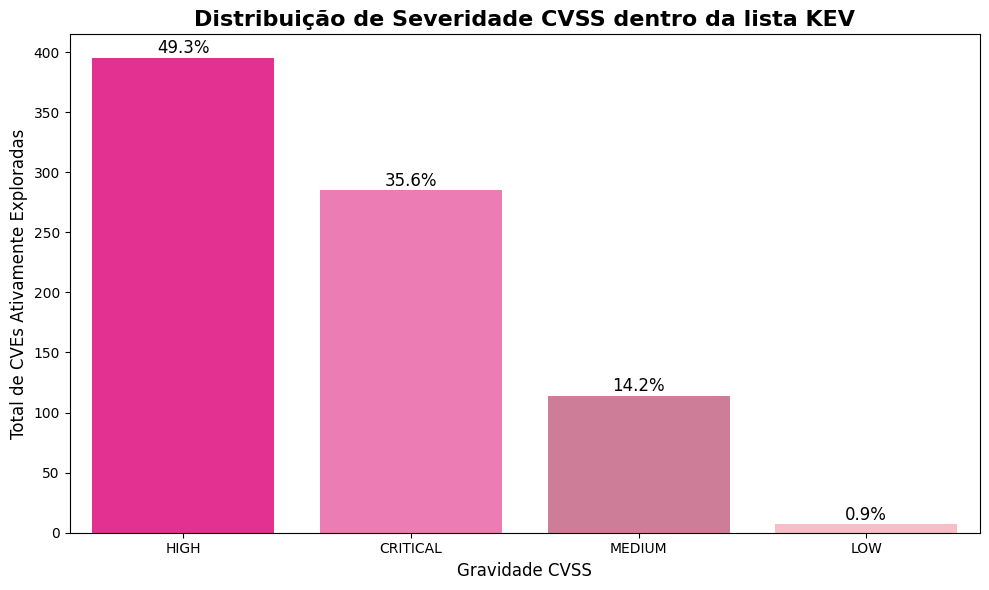

In [174]:
cores_insight_2 = ['#FF1493', '#FF69B4', '#DB7093', '#FFB6C1']

plt.figure(figsize=(10, 6))
ax_kev = sns.barplot(
    x=dist_kev_df.index,
    y=dist_kev_df['Total na KEV'],
    palette=cores_insight_2,
    hue=dist_kev_df.index,
    legend=False
)
plt.title('Distribuição de Severidade CVSS dentro da lista KEV', fontsize=16, weight='bold')
plt.xlabel('Gravidade CVSS', fontsize=12)
plt.ylabel('Total de CVEs Ativamente Exploradas', fontsize=12)

for i, p in enumerate(ax_kev.patches):
    percentage = f"{dist_kev_df['Porcentagem (%)'].iloc[i]:.1f}%"
    ax_kev.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()

## 🤖 Etapa 3: O Poder Preditivo
- Existe correlação entre o CVSS Base Score e o EPSS Score?  
- Quantas CVEs “Críticas” (CVSS ≥ 9.0) possuem probabilidade de exploração **baixa** (EPSS < 0.05)?  
- Quantas CVEs “Médias” ou “Altas” possuem probabilidade de exploração **alta** (EPSS > 0.90)?  


In [175]:
high_cvss_threshold = 9.0
medium_low_cvss_threshold = 7.0
low_epss_threshold = 0.05
high_epss_threshold = 0.75

correlation = df_nvd['pontuacao_cvss_v3'].corr(df['epss_score'])

false_positives = df[
    (df_nvd['pontuacao_cvss_v3'] >= high_cvss_threshold) &
    (df['epss_score'] < low_epss_threshold)
]

hidden_risks = df[
    (df_nvd['pontuacao_cvss_v3'] < medium_low_cvss_threshold) &
    (df['epss_score'] > high_epss_threshold)
]

In [176]:
print(f"Coeficiente de correlação de Pearson entre CVSS Base Score e EPSS Score: {correlation:.4f}")

# The scatter plot was already generated in the previous step, so we don't need to regenerate it.
# We will just rely on the output from the previous cell.

print(f"\nFalsos Alarmes (CVSS >= {high_cvss_threshold}, EPSS < {low_epss_threshold}):")
print(f"Estes são alertas com alta pontuação CVSS que têm uma probabilidade de exploração muito baixa de acordo com o EPSS.")
print(f"Número total de falsos alarmes encontrados: {len(false_positives)}")


print(f"\nRiscos Ocultos (CVSS < {medium_low_cvss_threshold}, EPSS > {high_epss_threshold}):")
print(f"Estes são riscos que têm baixa/média pontuação CVSS mas uma probabilidade de exploração extremamente alta de acordo com o EPSS.")
print(f"Número total de riscos ocultos encontrados: {len(hidden_risks)}")

Coeficiente de correlação de Pearson entre CVSS Base Score e EPSS Score: 0.5945

Falsos Alarmes (CVSS >= 9.0, EPSS < 0.05):
Estes são alertas com alta pontuação CVSS que têm uma probabilidade de exploração muito baixa de acordo com o EPSS.
Número total de falsos alarmes encontrados: 0

Riscos Ocultos (CVSS < 7.0, EPSS > 0.75):
Estes são riscos que têm baixa/média pontuação CVSS mas uma probabilidade de exploração extremamente alta de acordo com o EPSS.
Número total de riscos ocultos encontrados: 121


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


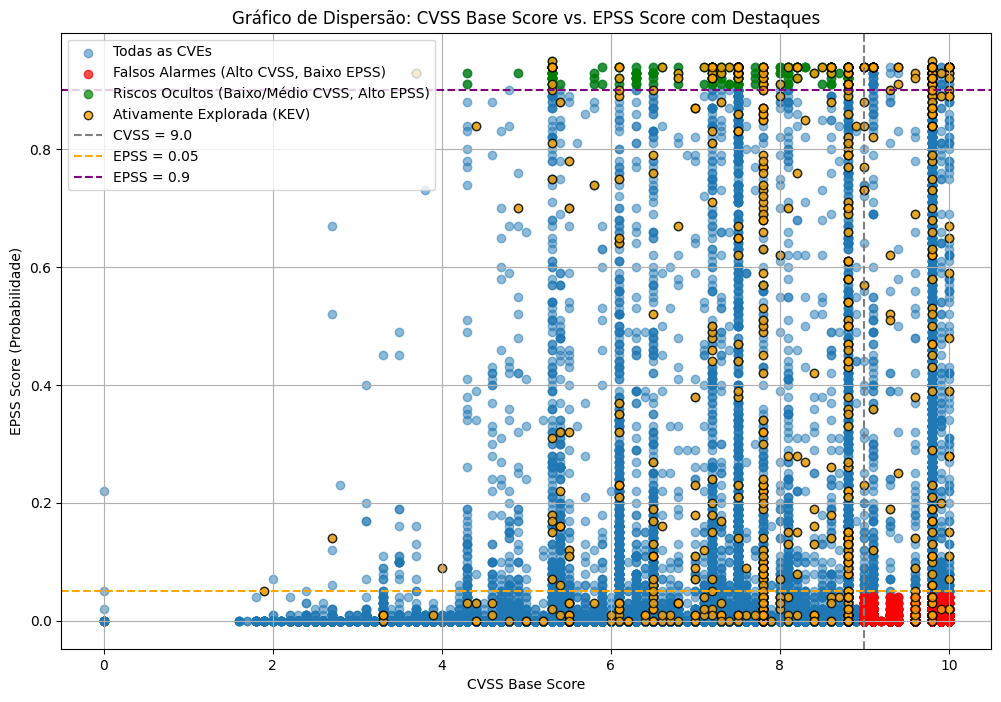

In [177]:
plt.figure(figsize=(12, 8))

# Define thresholds
high_cvss_threshold = 9.0
low_epss_threshold = 0.05
high_epss_threshold = 0.90
medium_low_cvss_threshold = 9.0 # CVSS < 9.0

# Merge the two dataframes on the CVE ID
df_merged = pd.merge(df_nvd, df, left_on='id_cve', right_on='cve_id', how='left')

# Scatter plot for all points
plt.scatter(df_merged['pontuacao_cvss_v3'], df_merged['epss_score'], alpha=0.5, label='Todas as CVEs')

# Highlight False Positives (High CVSS, Low EPSS)
false_positives_plot = df_merged[(df_merged['pontuacao_cvss_v3'] >= high_cvss_threshold) & (df_merged['epss_score'] < low_epss_threshold)]
plt.scatter(false_positives_plot['pontuacao_cvss_v3'], false_positives_plot['epss_score'], color='red', label='Falsos Alarmes (Alto CVSS, Baixo EPSS)', alpha=0.7)

# Highlight Hidden Risks (Medium/Low CVSS, High EPSS)
hidden_risks_plot = df_merged[(df_merged['pontuacao_cvss_v3'] < medium_low_cvss_threshold) & (df_merged['epss_score'] > high_epss_threshold)]
plt.scatter(hidden_risks_plot['pontuacao_cvss_v3'], hidden_risks_plot['epss_score'], color='green', label='Riscos Ocultos (Baixo/Médio CVSS, Alto EPSS)', alpha=0.7)

# Highlight Actively Exploited CVEs
actively_exploited = df_merged[df_merged['explorada_ativamente'] == 'SIM - Explorada (KEV)']
plt.scatter(actively_exploited['pontuacao_cvss_v3'], actively_exploited['epss_score'], color='orange', label='Ativamente Explorada (KEV)', alpha=0.8, edgecolors='black')


# Add reference lines
plt.axvline(x=high_cvss_threshold, color='gray', linestyle='--', label=f'CVSS = {high_cvss_threshold}')
plt.axhline(y=low_epss_threshold, color='orange', linestyle='--', label=f'EPSS = {low_epss_threshold}')
plt.axhline(y=high_epss_threshold, color='purple', linestyle='--', label=f'EPSS = {high_epss_threshold}')

plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score (Probabilidade)')
plt.title('Gráfico de Dispersão: CVSS Base Score vs. EPSS Score com Destaques')
plt.legend()
plt.grid(True)
plt.show()